In [2]:
from transformers import SamModel, SamConfig, SamProcessor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import torch

/home/flight/feedback/segment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


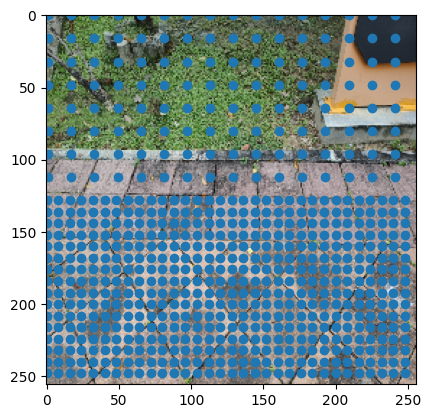

In [3]:
size = (256, 256)
points = []

for i in range(0, int(size[0]/2), 16):
    for j in range(1, size[1], 16):
        points.append([j, i])

for i in range(size[0]//2, size[0], 8):
    for j in range(0, size[1], 8):
        points.append([j, i])

points = np.array(points)

img = cv2.cvtColor(cv2.imread('./img/dataset/11.png'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, size)

plt.imshow(img)

x, y = points.T
plt.scatter(x, y)
plt.show()

In [4]:
model_config = SamConfig.from_pretrained(r'./weight/sam/config.json')
processor = SamProcessor.from_pretrained('facebook/sam-vit-base')

In [5]:
model = SamModel(config=model_config)
model.load_state_dict(torch.load(r'./weight/best.pth'))

<All keys matched successfully>

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

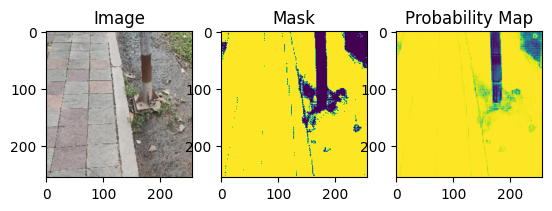

In [48]:
image = np.array(cv2.cvtColor(cv2.imread(r'./right.png'), cv2.COLOR_BGR2RGB))
image = cv2.resize(image, (256, 256))

inputs = processor(image, input_points=[[points]], return_tensors='pt')
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()

with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

seg_prob = prob.cpu().numpy().squeeze()
seg = np.where(seg_prob>0.95, 255, 0)

fig, axes = plt.subplots(1, 3)

axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(seg)  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

plt.show()

In [8]:
# def draw_mask(img: np.array, seg_prob: np.array, thersh: float):
#     mask_img = img.copy()
# 
#     mask_img = np.where(seg_prob>=thersh, np.array([255, 0, 0], dtype=np.uint8), mask_img)
# 
#     mask_img = mask_img.astype(np.uint8)
# 
#     return cv2.addWeighted(img, 0.1, mask_img, 0.9, 0)

In [9]:
# image = np.array(cv2.imread(r'./img/dataset/10.png'))
# image = cv2.resize(image, (256, 256))
# 
# inputs = processor(image, input_points=[[points]], return_tensors='pt')
# inputs = {k: v.to(device) for k, v in inputs.items()}
# 
# model.eval()
# 
# with torch.no_grad():
#     outputs = model(**inputs, multimask_output=False)
# 
# prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# seg_prob = prob.cpu().numpy().squeeze()
# 
# zero = np.zeros((256, 256), dtype=np.uint8)
# prob_3d = np.dstack((seg_prob, zero, zero))
# 
# cv2.imshow('result', draw_mask(image, prob_3d, 0.9))
# cv2.waitKey(1)

In [10]:
# cv2.destroyAllWindows()

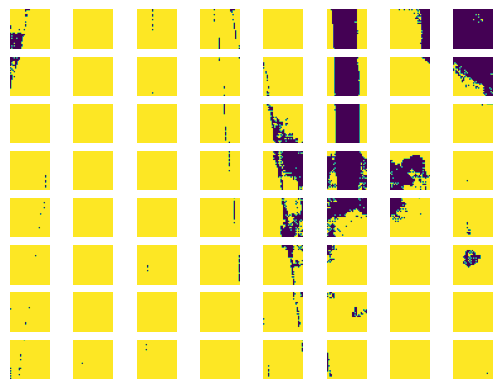

In [49]:
# Seperate the image in to 8 pices

frac = [[] for i in range(8)]

for i, f in enumerate(frac):
    for j in range(0, 225, 32):
        f.append(seg[32*(len(frac)-1-i):32*((len(frac)-1-i)+1), j:32+j])

fig, axes = plt.subplots(8, 8)

for i, arr in enumerate(frac):
    for j, img in enumerate(arr):
        axes[len(frac)-1-i][j].imshow(img, vmin=0, vmax=255)
        axes[len(frac)-1-i][j].axis('off')
        axes[len(frac)-1-i][j].autoscale(False)

plt.show()


In [50]:
direction = []

for i, arr in enumerate(frac):
    l = (len(arr)-1)//2
    r = l + 1
    weight_l, weight_r = 0, 0

    while l >= 0 and r <= len(arr)-1:

        if weight_l and weight_r:
            break
        
        if not weight_l:
            # Find The most repeated element in array (more than 50%)
            ptype = int(np.argmax(np.bincount(arr[l].ravel())))

            if not ptype:
                weight_l = int(l*10)
        
        if not weight_r:
            ptype = int(np.argmax(np.bincount(arr[r].ravel())))
            
            if not ptype:
                weight_r = (7-r)*10
        
        # find the easiest way to avoid obstacle
        if weight_l == 30 and weight_r == 30:
            sl, sr = 0, len(arr)-1
            co_l, co_r = 0, 0
            path_l, path_r = None, None

            while sl < l and sr > r:
                print(i, end=": ")
                # check left
                ptype = int(np.argmax(np.bincount(arr[sl].ravel())))
                if ptype == 255:
                    co_l += 1
                else:
                    co_l = 0

                if co_l >= 2:
                        path_l = sl
                print("lhs", ptype, co_l, end=" ")

                # check right
                ptype = int(np.argmax(np.bincount(arr[sr].ravel())))
                if ptype == 255:
                    co_r += 1
                else:
                    co_r = 0

                if co_r >= 2:
                        path_r = sr
                print("rhs", ptype, co_r)

                sl += 1
                sr -= 1
            
            if path_l is not None or path_r is not None:
                # Left hand side cannot go
                if path_l is None:
                    weight_r = 0
                    weight_l = path_r*10
                    break
                # Right hand side cannot go
                elif path_r is None:
                    weight_l = 0
                    weight_r = ((len(arr)-1)-path_l)*10
                else:
                    # Turn right
                    if abs(l - path_l) > abs(path_r - r):
                        weight_r = 0
                        weight_l = path_r*10
                    # Turn left
                    elif abs(l - path_l) < abs(path_r - r):
                        weight_l = 0
                        weight_r = ((len(arr)-1)-path_l)*10
                    # Any direction
                    elif co_l >= 2:
                        weight_l = int(777)
                        weight_r = 0
            # Cannot pass
            else:
                weight_l = 0
                weight_r = int(777)

        l -= 1
        r += 1

    # (-) means turn left, (+) means turn right, 777 means either left or right, and -777 means impossible to pass
    direction.append(weight_l-weight_r)

print(direction)

[0, 0, 0, 0, -20, -20, -20, -20]
